# Showcase how to run and plot a simulation of virtual Argo floats

Requirements:
- Velocity fields from Mercator forecast ([GLOBAL-ANALYSIS-FORECAST-PHY-001-024](https://resources.marine.copernicus.eu/?option=com_csw&task=results?option=com_csw&view=details&product_id=GLOBAL_ANALYSIS_FORECAST_PHY_001_024))
- Requirements, Python libraries:

    ```bash
    pip install progressbar cgen pymbolic
    ```

***
Script prepared by [Kevin Balem](http://github.com/quai20) (Feb. 2020)

This work is part and was supported by the following projects:
<div>
<img src="https://avatars1.githubusercontent.com/u/58258213?s=460&v=4" width="70"/>
<img src="http://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="200"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70"/>
</div>

In [17]:
# !pip install progressbar
# !pip install cgen
# !pip install pymbolic
import parcels
parcels.__version__

'2.2.1.dev45+g00953f31'

In [1]:
import sys
import numpy as np
import xarray as xr

sys.path.insert(0, "..")
import virtualargofleet as vaf

import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])

# Set-up the velocity field

In [5]:
# Set how to find the velocity field
src = "/home/datawork-lops-oh/somovar/WP1/data/GLOBAL-ANALYSIS-FORECAST-PHY-001-024"
src = "/Users/gmaze/data/MERCATOR/data/GLOBAL-ANALYSIS-FORECAST-PHY-001-024"

filenames = {'U': src + "/*.nc",
             'V': src + "/*.nc"}
variables = {'U':'uo','V':'vo'}
dimensions = {'time': 'time', 'depth':'depth', 'lat': 'latitude', 'lon': 'longitude'}

In [6]:
# Ddefine the velocity field object of the VF:
# USAGE : obj = vaf.velocityfield(ds=filenames, var=variables, dim=dimensions, isglobal=0 or 1) 
VELfield = vaf.velocityfield(ds=filenames, var=variables, dim=dimensions, isglobal=0)

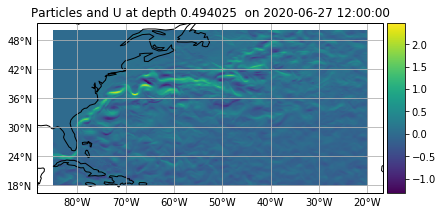

In [7]:
VELfield.plot()

# Create deployment plan of virtual Argo floats

## Plan A: Small rectangular

In [9]:
# Number of float we want to simulate
nfloats = 10

# Then we must define numpy array (size nfloats) for lat, lon, depth and time
lat0 = 36.00
lon0 = -50.00
t0 = np.datetime64('2018-01-01')
lon = np.random.uniform(lon0-1.0, lon0+1.0, size=nfloats)
lat = np.random.uniform(lat0-1.0, lat0+1.0, size=nfloats)
depth = np.linspace(1.0,1.0,nfloats) #1m depth
ti = np.empty(nfloats,dtype='datetime64[D]')
ti[:] = t0

# DEFINE THE FLOAT OBJECT
# USAGE : obj=virtualfloat(lat=lat_array,lon=lon_array,depth=depth_array,
#                          time=time_array,vfield=velocity_field_object) 
VFleet = vaf.virtualfleet(lat=lat, lon=lon, depth=depth, time=ti, vfield=VELfield)

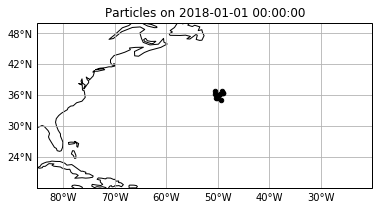

In [10]:
VFleet.plotfloat()

# Run the virtual fleet simulation

In [11]:
%%time
run_outputs = "out"
output_file = run_outputs + '/test_20200225_a.nc'
# USAGE : float_object.simulate(duration=days,dt_run=hours,dt_out=hours,output_file='my_advection_nXX.nc')
VFleet.simulate(duration=365*2, dt_run=1./12, dt_out=24, output_file=output_file)

INFO: Compiled ArgoParticleArgoVerticalMovementAdvectionRK4 ==> /var/folders/ww/psmkfjds7xsc4kjsz66ghldr000nsn/T/parcels-22325/036626a2689dbb68b51e5ca90166b748_0.so
INFO: Temporary output files are stored in out/out-EHHENXTK.
INFO: You can use "parcels_convert_npydir_to_netcdf out/out-EHHENXTK" to convert these to a NetCDF file during the run.
100% |########################################################################|


CPU times: user 18.1 s, sys: 7.22 s, total: 25.4 s
Wall time: 26.7 s


# Plot the virtual fleet simulation

In [13]:
# Load simulation results:
simu = xr.open_dataset(output_file)
print(simu)

# And velocity field to superimpose on plot:
velo = xr.open_dataset(src + '/20200627_global-analysis-forecast-phy-001-024.nc')

<xarray.Dataset>
Dimensions:      (obs: 731, traj: 10)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory   (traj, obs) float64 ...
    time         (traj, obs) datetime64[ns] ...
    lat          (traj, obs) float32 ...
    lon          (traj, obs) float32 ...
    z            (traj, obs) float32 ...
    cycle_phase  (traj, obs) float32 ...
    cycle_age    (traj, obs) float32 ...
    drift_age    (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.1.dev45+g00953f31
    parcels_mesh:           spherical


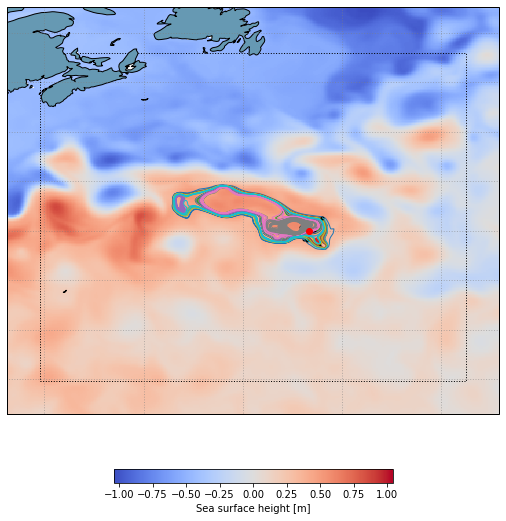

In [14]:
pr1=ccrs.PlateCarree()
# pr2=ccrs.LambertConformal(-72,35,false_easting=0.0, false_northing=0.0, secant_latitudes=None, standard_parallels=None, cutoff=-30)

fig=plt.figure(figsize=(10,10))
ax3 = fig.add_subplot(1,1,1,projection=pr1)
ax3.add_feature(land_feature, edgecolor='black')
ax3.set_extent([simu.lon.min()-10, simu.lon.max()+10, simu.lat.min()-10, simu.lat.max()+10])

ax3.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle=':')

velo['zos'][0][:][:].plot(cmap=plt.cm.coolwarm,
                          cbar_kwargs={'orientation': 'horizontal', 'shrink':0.5, 'pad':0.1},
                          transform=pr1)

for i in simu['traj']:
    this = simu.isel(traj=i).sortby('time')
    ax3.plot(this['lon'][0], this['lat'][0],'k.', transform=pr1)
    ax3.plot(this['lon'], this['lat'], linewidth=1, transform=pr1)


ax3.plot(lon0, lat0, 'or', 'markersize', 4, transform=pr1)
ax3.add_patch(mpatches.Rectangle(xy=[simu.lon.min()-8, simu.lat.min()-8], 
                                 width=(simu.lon.max()-simu.lon.min()+16), 
                                 height=(simu.lat.max()-simu.lat.min()+16),
                                 edgecolor='k',facecolor='none',linestyle=':',transform=pr1))

plt.title("");

In [16]:
trj = simu.isel(traj=0)
plt.plot

<xarray.Dataset>
Dimensions:      (obs: 731)
Dimensions without coordinates: obs
Data variables:
    trajectory   (obs) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    time         (obs) datetime64[ns] 2018-01-01 2018-01-02 ... 2020-01-01
    lat          (obs) float32 35.483955 35.52421 ... 36.52767 36.429836
    lon          (obs) float32 -50.29028 -50.397625 ... -49.16917 -49.128418
    z            (obs) float32 1.0 1000.00006 1000.00006 ... 1019.0 1019.0
    cycle_phase  (obs) float32 0.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    cycle_age    (obs) float32 0.0 86400.0 172800.0 ... 533400.0 619800.0
    drift_age    (obs) float32 0.0 75300.0 161700.0 ... 522000.0 608400.0
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.1.dev45+g00953f31
    parcels_mesh:           spherical